In [1]:
# Standard library imports
import os
import traceback
# Third-party library imports
import holidays
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K # For Keras backend functionalities

from matplotlib import pyplot as plt

from scikeras.wrappers import KerasRegressor # For Keras model in GridSearchCV

from sklearn.ensemble import RandomForestRegressor # For Random Forest model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit # For hyperparameter tuning and CV
from sklearn.metrics import mean_squared_error, mean_absolute_error # For model evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler # For data scaling

from tensorflow.keras.callbacks import EarlyStopping # For early stopping during training
from tensorflow.keras.layers import (LSTM, Conv1D, Dense, Activation, # Core Keras layers
                                   Dropout, Flatten, MaxPooling1D, Input)
from tensorflow.keras.models import Sequential # For building sequential Keras models
from tensorflow.keras.optimizers import Adam, Nadam # Keras optimizers
from tensorflow.keras.regularizers import l2 # For L2 regularization

In [2]:
import sklearn
import scikeras
import tensorflow

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"SciKeras version: {scikeras.__version__}")
print(f"TensorFlow version: {tensorflow.__version__}")

Scikit-learn version: 1.5.0
SciKeras version: 0.13.0
TensorFlow version: 2.16.1


In [3]:
# path = "C:/Users/harry/OneDrive/Desktop/Py models/"
# file_path=os.path.join(path,"dummy_data.csv")
df = pd.read_csv('dummy_data.csv',parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df.head()


,date,Total_Presented,capacity,RollCap
0,2022-01-01,83833,24140,24140
1,2022-01-02,82527,24201,48341
2,2022-01-03,102403,26989,75330
3,2022-01-04,101309,27907,103237
4,2022-01-05,97056,25540,128777


In [4]:
df.tail()

,date,Total_Presented,capacity,RollCap
1091,2024-12-27,88532,24076,727188
1092,2024-12-28,82658,24231,726681
1093,2024-12-29,87544,24251,729699
1094,2024-12-30,97219,26934,734638
1095,2024-12-31,101389,26164,738874


In [5]:
test=[]
for hd in holidays.UnitedStates(years = [2021,2022,2023,2024,2025]).items():
     test.append(hd)
test_df=pd.DataFrame(test,columns=['date','holiday'])
test_df.drop_duplicates(subset='date', keep='first',inplace=True)
test_df

,date,holiday
0,2021-01-01,New Year's Day
1,2021-12-31,New Year's Day (observed)
2,2021-05-31,Memorial Day
3,2021-06-19,Juneteenth National Independence Day
4,2021-06-18,Juneteenth National Independence Day (observed)
...,...,...
58,2025-11-27,Thanksgiving Day
59,2025-12-25,Christmas Day
60,2025-01-20,Martin Luther King Jr. Day
61,2025-02-17,Washington's Birthday


In [6]:
holiday_list=[]
for hd in holidays.UnitedStates(years = [2021,2022,2023,2024,2025]).items():
  holiday_list.append(hd)

holiday_df = pd.DataFrame(holiday_list, columns=['date', 'holiday'])
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.info()
holiday_df.head()
holiday_df.drop_duplicates(subset='date', keep='first',inplace=True)
holiday_df[holiday_df['date']=='2021-12-31']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     63 non-null     datetime64[ns]
 1   holiday  63 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.1+ KB


,date,holiday
1,2021-12-31,New Year's Day (observed)


In [7]:
us_holidays_name=["New Year's Day","New Year's Day (observed)","Memorial Day","Independence Day",
                  "Labor Day","Thanksgiving","Christmas Day"]
print(us_holidays_name)


["New Year's Day", "New Year's Day (observed)", 'Memorial Day', 'Independence Day', 'Labor Day', 'Thanksgiving', 'Christmas Day']


In [8]:
holiday_df.head

<bound method NDFrame.head of          date                                          holiday
0  2021-01-01                                   New Year's Day
1  2021-12-31                        New Year's Day (observed)
2  2021-05-31                                     Memorial Day
3  2021-06-19             Juneteenth National Independence Day
4  2021-06-18  Juneteenth National Independence Day (observed)
..        ...                                              ...
58 2025-11-27                                 Thanksgiving Day
59 2025-12-25                                    Christmas Day
60 2025-01-20                       Martin Luther King Jr. Day
61 2025-02-17                            Washington's Birthday
62 2025-10-13                                     Columbus Day

[63 rows x 2 columns]>

In [9]:
merged_df=pd.merge(df,holiday_df,how='left',left_on='date',right_on='date')

In [10]:
Holiday_A_Names=["Thanksgiving","Christmas Day"]

In [11]:
merged_df['Holiday_A']=merged_df['holiday'].apply(lambda x: 1 if x in Holiday_A_Names else 0)
merged_df['Holiday_B']=merged_df['holiday'].apply(lambda x: 1 if x not in Holiday_A_Names and x in us_holidays_name else 0)
merged_df['weekday']=merged_df['date'].dt.dayofweek
merged_df['week_number'] = merged_df['date'].dt.isocalendar().week
merged_df['month'] = merged_df['date'].dt.month #add month column
merged_df.head(80)
merged_df[merged_df['Holiday_A']==1]
#0 Mon - 6 Sun

,date,Total_Presented,capacity,RollCap,holiday,Holiday_A,Holiday_B,weekday,week_number,month
358,2022-12-25,87239,24308,717182,Christmas Day,1,0,6,51,12
723,2023-12-25,98134,26687,721053,Christmas Day,1,0,0,52,12
1089,2024-12-25,97628,25137,725412,Christmas Day,1,0,2,52,12


In [12]:
#Final dataset
merged_df=merged_df.loc[:,['Total_Presented','RollCap','Holiday_A','Holiday_B','weekday','week_number','month']]
merged_df.index=pd.to_datetime(df['date'])
monthly_sum=merged_df['Total_Presented'].resample('MS').sum() 
daily_data=pd.DataFrame(index=pd.date_range(start=merged_df.index.min(),end=merged_df.index.max()))
daily_data['month_start']=daily_data.index.to_period('M').to_timestamp()

#merge monthly
merged_monthly_sum=daily_data.merge(monthly_sum,left_on='month_start',right_index=True,how='left')
#merge back
merged_df['monthly_sum']=merged_monthly_sum['Total_Presented'].values
merged_df.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2022-01-01,83833,24140,0,1,5,52,1,2905710
2022-01-02,82527,48341,0,0,6,52,1,2905710
2022-01-03,102403,75330,0,0,0,1,1,2905710
2022-01-04,101309,103237,0,0,1,1,1,2905710
2022-01-05,97056,128777,0,0,2,1,1,2905710


In [13]:
merged_df.tail(30)

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2024-12-02,99776,700584,0,0,0,49,12,2863065
2024-12-03,101125,706122,0,0,1,49,12,2863065
2024-12-04,96471,705745,0,0,2,49,12,2863065
2024-12-05,91345,704721,0,0,3,49,12,2863065
2024-12-06,86218,702680,0,0,4,49,12,2863065
2024-12-07,80001,703320,0,0,5,49,12,2863065
2024-12-08,84699,703341,0,0,6,49,12,2863065
2024-12-09,100163,705745,0,0,0,50,12,2863065
2024-12-10,101267,709921,0,0,1,50,12,2863065


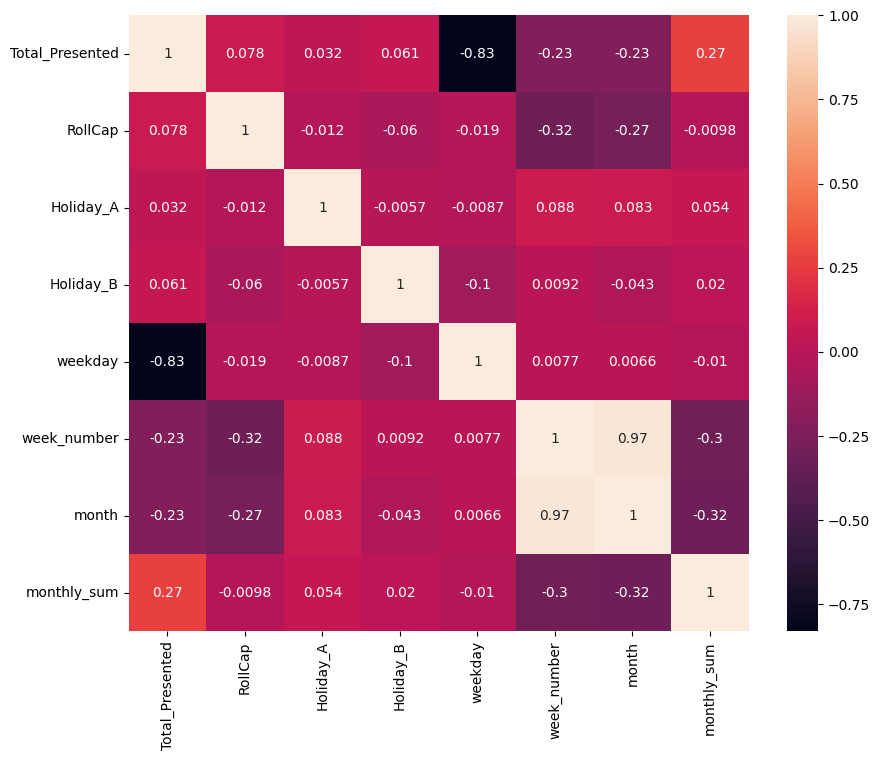

In [14]:
# corr_cal before training
correlation_matrix = merged_df.corr()

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

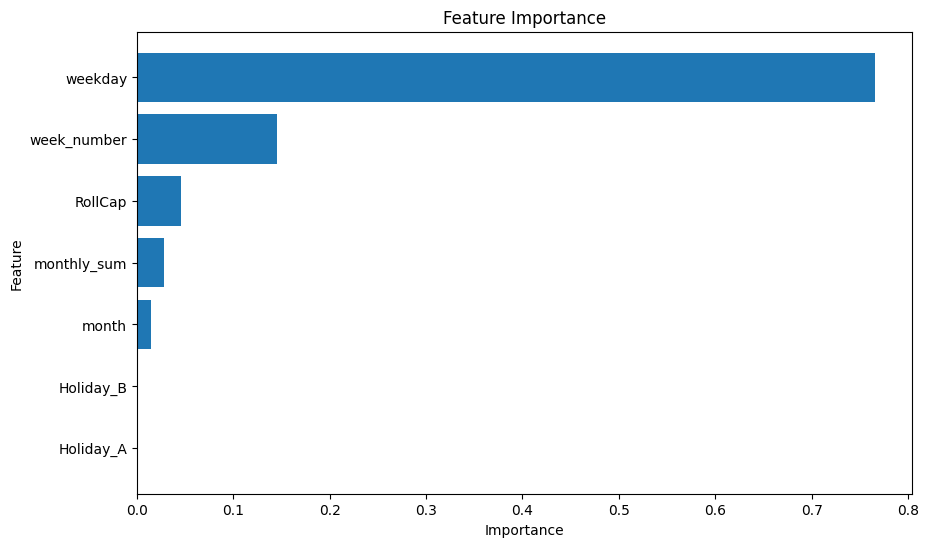

In [15]:
# Splitting data into features and target variable
X = merged_df.drop('Total_Presented', axis=1)  # Assuming 'Total_Presented' is the target variable
y = merged_df['Total_Presented']

# Create the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for the importances
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features based on importance
features = features.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [16]:
merged_df.index=pd.to_datetime(merged_df.index)

In [17]:
merged_df.shape

(1096, 8)

In [18]:
#split test and training set
test_split = int(len(merged_df)*0.95)
df_for_training=merged_df[:test_split]
df_for_testing=merged_df[test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(1041, 8)
(55, 8)


In [19]:
df_for_training.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2022-01-01,83833,24140,0,1,5,52,1,2905710
2022-01-02,82527,48341,0,0,6,52,1,2905710
2022-01-03,102403,75330,0,0,0,1,1,2905710
2022-01-04,101309,103237,0,0,1,1,1,2905710
2022-01-05,97056,128777,0,0,2,1,1,2905710


In [20]:
df_for_testing.tail()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2024-12-27,88532,727188,0,0,4,52,12,2863065
2024-12-28,82658,726681,0,0,5,52,12,2863065
2024-12-29,87544,729699,0,0,6,52,12,2863065
2024-12-30,97219,734638,0,0,0,1,12,2863065
2024-12-31,101389,738874,0,0,1,1,12,2863065


In [21]:
#scale progress
#columns_to_scale 
columns_to_scale=['Total_Presented','RollCap','monthly_sum']
scaler=MinMaxScaler(feature_range=(0,1))
df_for_training_scaled=df_for_training.copy()
df_for_testing_scaled=df_for_testing.copy()
df_for_training_scaled[columns_to_scale]=scaler.fit_transform(df_for_training[columns_to_scale])
df_for_testing_scaled[columns_to_scale]=scaler.transform(df_for_testing[columns_to_scale])
df_for_training_scaled.head()
#df_for_testing_scaled.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2022-01-01,0.144125,0.000000,0,1,5,52,1,0.961492
2022-01-02,0.095005,0.029932,0,0,6,52,1,0.961492
2022-01-03,0.842561,0.063311,0,0,0,1,1,0.961492
2022-01-04,0.801414,0.097826,0,0,1,1,1,0.961492
2022-01-05,0.641455,0.129414,0,0,2,1,1,0.961492


In [22]:
print(df_for_training[['monthly_sum']].describe)

<bound method NDFrame.describe of             monthly_sum
date                   
2022-01-01      2905710
2022-01-02      2905710
2022-01-03      2905710
2022-01-04      2905710
2022-01-05      2905710
...                 ...
2024-11-02      2688079
2024-11-03      2688079
2024-11-04      2688079
2024-11-05      2688079
2024-11-06      2688079

[1041 rows x 1 columns]>


In [23]:
df_for_testing_scaled.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2024-11-07,0.548217,0.821765,0,0,3,45,11,0.278756
2024-11-08,0.130435,0.819551,0,0,4,45,11,0.278756
2024-11-09,0.000000,0.819400,0,0,5,45,11,0.278756
2024-11-10,0.135851,0.817724,0,0,6,45,11,0.278756
2024-11-11,0.656424,0.822511,0,0,0,46,11,0.278756


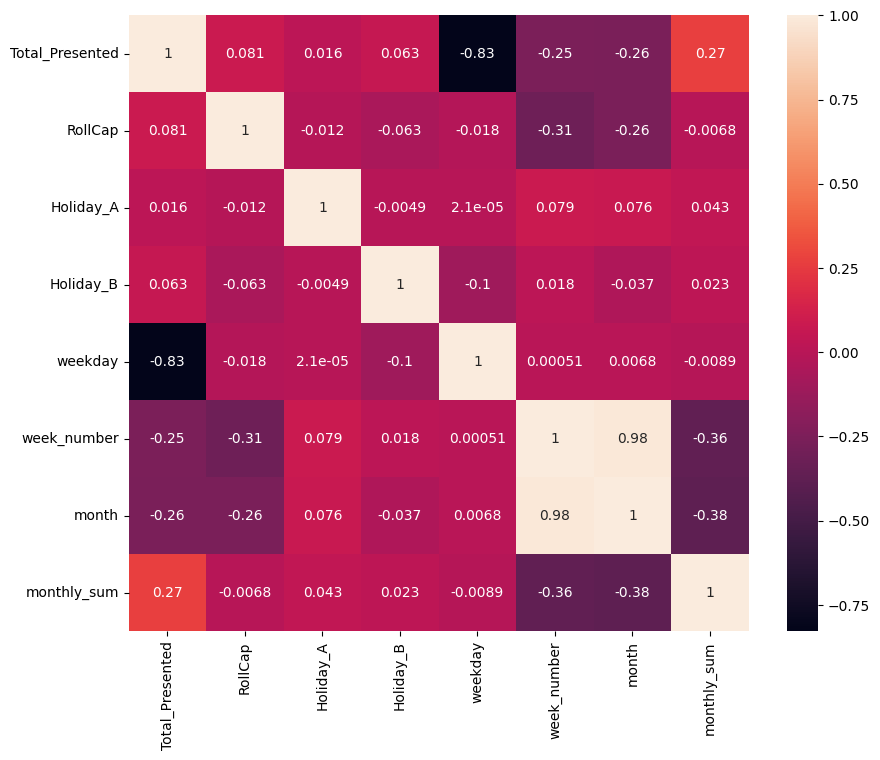

In [24]:
# corr_cal before training
correlation_matrix = df_for_training_scaled.corr()

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [25]:
n_past_steps = 7 #Define the look-back window size
n_features= 8 #Define the number of features

In [26]:
def createXY(dataset,n_past):
  dataX=[]
  dataY=[]
  for i in range(n_past,len(dataset)):
    dataX.append(dataset[i-n_past:i,0:dataset.shape[1]])
    dataY.append(dataset[i,0])
  return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled.values,n_past_steps)
testX,testY=createXY(df_for_testing_scaled.values,n_past_steps)

In [27]:
# convert to float32
testX = testX.astype('float32')
testY = testY.astype('float32')



In [28]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1034, 7, 8)
(1034,)
(48, 7, 8)
(48,)


In [29]:
print(trainX[0])
print(trainY[0])

[[0.14412516924928553 0.0 0 1 5 52 1 0.9614917666103029]
 [0.09500526553332334 0.02993154369886648 0 0 6 52 1 0.9614917666103029]
 [0.8425605536332181 0.06331125664001384 0 0 0 1 1 0.9614917666103029]
 [0.80141417180683 0.09782634238044884 0 0 1 1 1 0.9614917666103029]
 [0.6414547916353244 0.12941394727566186 0 0 2 1 1 0.9614917666103029]
 [0.3501955769520082 0.1602471105504332 0 0 3 1 1 0.9614917666103029]
 [0.516135098540695 0.19256813164387881 0 0 4 1 1 0.9614917666103029]]
0.13949902211524012


In [30]:
print("Setting up model definition and GridSearchCV components...")

# -----------------------------------
# 1. Model Building Function
# (Using MSE loss as it was working previously, can be changed if needed)
# -----------------------------------
def build_model(optimizer='adam', learning_rate=0.001):
    """Builds the Keras Conv1D + LSTM model."""
    # Select optimizer instance
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate) # Default to Adam

    grid_model = Sequential(name="Conv1D_LSTM_Model")
    # Input shape: (time_steps, num_features) - Ensure this matches your trainX shape
    # NOTE: Using hardcoded shape (7, 8) for Input layer.
    # Using global variables (n_past_steps, n_features) directly caused issues
    # when this function is called by GridSearchCV/KerasRegressor,
    # possibly due to context/scoping issues in their execution environment.
    # Ensure these hardcoded values match the intended n_past_steps and n_features.
    grid_model.add(Input(shape=(7, 8), name="Input_Layer"))
    grid_model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', kernel_initializer="glorot_uniform", name="Conv1D_1"))
    grid_model.add(Dropout(0.1, name="Dropout_Conv"))  # 
    grid_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer="glorot_uniform", name="Conv1D_2"))
    grid_model.add(LSTM(96, return_sequences=True, kernel_regularizer=l2(0.001), name="LSTM_1"))
    grid_model.add(Dropout(0.2, name="Dropout_1"))
    grid_model.add(LSTM(48, return_sequences=True, kernel_regularizer=l2(0.001), name="LSTM_2"))
    grid_model.add(Dropout(0.25, name="Dropout_2"))
    grid_model.add(LSTM(48, return_sequences=False, kernel_regularizer=l2(0.001), name="LSTM_3")) # Last LSTM has return_sequences=False
    grid_model.add(Dropout(0.3, name="Dropout_3"))
    grid_model.add(Dense(32, activation="relu", kernel_initializer="uniform", name="Dense_1"))
    grid_model.add(Dropout(0.2, name="Dropout_4"))
    # Output layer activation: 'relu' assumes non-negative output. Use 'linear' if output can be negative.
    grid_model.add(Dense(1, activation="relu", kernel_initializer="uniform", name="Output_Dense"))

    # Compile using MSE loss (aligns with neg_mean_squared_error scoring)
    grid_model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse'])
    return grid_model

# -----------------------------------
# 2. Scikeras Wrapper
# -----------------------------------
keras_estimator = KerasRegressor(
    model=build_model,
    loss="mse",          # Loss function used for training (matches compile)
    optimizer="adam",    # Default optimizer name (will be overridden by grid search)
    verbose=1           # Keras verbose level during grid search fits (0=silent, 1=progress bar)
                         # GridSearchCV's verbose controls overall output.
)

# -----------------------------------
# 3. Hyperparameter Grid
# -----------------------------------
parameters = {
    'batch_size': [16,32],                # Parameter for Keras fit method
    'epochs': [30,50],                    # Parameter for Keras fit method (use small values for testing)
    'optimizer': ['adam', 'nadam'],        # Parameter passed to build_model
    'optimizer__learning_rate': [0.005,0.001] # Parameter passed to the optimizer inside build_model
}

# -----------------------------------
# 4. Time Series Cross-Validator
# -----------------------------------
# Adjust n_splits based on your data size and computation time tolerance
tscv = TimeSeriesSplit(n_splits=3)

# -----------------------------------
# 5. GridSearchCV Object Creation
# (Using MSE scoring as it was working previously)
# -----------------------------------
grid_search = GridSearchCV(
    estimator=keras_estimator,
    param_grid=parameters,
    cv=tscv,
    scoring='neg_mean_squared_error', # Score models using Negative MSE
    verbose=2                         # Verbosity level for GridSearchCV output
)

# -----------------------------------
# 6. Early Stopping Callback
# -----------------------------------
# Monitors the training loss ('loss', which is MSE here)
early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,             # Number of epochs with no improvement after which training will be stopped.
    verbose=1,               # Print message when stopping occurs.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

print("\nModel definition and GridSearchCV setup complete.")
print("Objects created: build_model (function), keras_estimator, parameters, tscv, grid_search, early_stopping")
print("Next step: Ensure trainX and trainY are prepared, then run the execution block (Block 2).")


Setting up model definition and GridSearchCV components...

Model definition and GridSearchCV setup complete.
Objects created: build_model (function), keras_estimator, parameters, tscv, grid_search, early_stopping
Next step: Ensure trainX and trainY are prepared, then run the execution block (Block 2).


In [31]:
print("\nStarting Grid Search Execution...")

try:
    # Fit GridSearchCV to the training data
    # This performs the cross-validation and hyperparameter search
    grid_search.fit(trainX, trainY, callbacks=[early_stopping])

    # --- Results ---
    print("\nGrid search completed successfully!")
    print(f"Best parameters found: {grid_search.best_params_}")

    # Display results using Negative Mean Squared Error (closer to 0 is better)
    print(f"Best score (neg_mean_squared_error): {grid_search.best_score_}")
    # Display the corresponding positive Mean Squared Error
    print(f"Best score (mean_squared_error): {-grid_search.best_score_}")

    # Get the best estimator found by the grid search
    best_estimator = grid_search.best_estimator_
    print("\nBest estimator obtained from grid search.")

    # --- Optional: Prediction and Evaluation on Test Set ---
    # Uncomment the following lines if you have testX and testY prepared

    # print("\nPredicting on test data using the best estimator...")
    # try:
    #     # Ensure testX and testY exist before uncommenting prediction/evaluation
    #     if 'testX' in locals() and 'testY' in locals():
    #         y_pred_test = best_estimator.predict(testX)
    #         # Calculate metrics on the original scale if you inverse_transform,
    #         # or on the scaled data here.
    #         mse_test_scaled = mean_squared_error(testY, y_pred_test)
    #         mae_test_scaled = mean_absolute_error(testY, y_pred_test) # Also calculate MAE if interested
    #         print(f"\nTest MSE on scaled data: {mse_test_scaled}")
    #         print(f"Test MAE on scaled data: {mae_test_scaled}")
    #
    #         # Optional: Plotting results
    #         # import matplotlib.pyplot as plt
    #         # plt.figure(figsize=(12, 6))
    #         # plt.plot(testY, label='Actual Test Data (Scaled)')
    #         # plt.plot(y_pred_test, label='Predicted Test Data (Scaled)', alpha=0.7)
    #         # plt.title('Test Data Prediction vs Actual (Scaled)')
    #         # plt.xlabel('Time Steps')
    #         # plt.ylabel('Scaled Value')
    #         # plt.legend()
    #         # plt.show()
    #     else:
    #          print("\nSkipping test set prediction/evaluation as testX or testY were not found.")
    #
    # except Exception as eval_e:
    #     print(f"\nAn error occurred during prediction or evaluation: {eval_e}")
    #     traceback.print_exc()


except NameError as ne:
    # This error will likely occur if trainX or trainY were not defined before running this block
    print(f"\nAn error occurred: {ne}")
    print("!!! ERROR: Make sure trainX and trainY variables exist and contain your data BEFORE running this execution block !!!")
    traceback.print_exc()
except Exception as e:
    # Catch other potential errors during the grid search fit process
    print(f"\nAn error occurred during grid search: {e}")
    traceback.print_exc()

print("\nExecution block finished.")



Starting Grid Search Execution...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4517 - mae: 0.3768 - mse: 0.2088
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2618 - mae: 0.2420 - mse: 0.0851
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2045 - mae: 0.2320 - mse: 0.0767
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1615 - mae: 0.2240 - mse: 0.0700
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1314 - mae: 0.2164 - mse: 0.0650
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1105 - mae: 0.2130 - mse: 0.0607
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0961 - mae: 0.2078 - mse: 0.0577
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0881 - mae: 0.2046 - mse: 0.0572
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0655 - mae: 0.1669 - mse: 0.0395
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465 -

In [32]:
grid_search.best_params_


{'batch_size': 32,
 'epochs': 30,
 'optimizer': 'adam',
 'optimizer__learning_rate': 0.005}

In [33]:
#my_model=grid_search.best_estimator_.model
my_model = grid_search.best_estimator_.model_

In [34]:
#evaluate
evaluation = my_model.evaluate(testX,testY,verbose=1)
print('Test loss(MSE):',evaluation[0])
print('Test loss(MAE):',evaluation[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098 - mae: 0.0711 - mse: 0.0079 
Test loss(MSE): 0.009861957281827927
Test loss(MAE): 0.07021638005971909


In [35]:
my_model

<Sequential name=Conv1D_LSTM_Model, built=True>

In [36]:
prediction = my_model.predict(testX)
print(prediction)
print(prediction.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
[[0.438368  ]
 [0.25053087]
 [0.08882931]
 [0.15264015]
 [0.61554885]
 [0.61097986]
 [0.48510554]
 [0.449028  ]
 [0.26637724]
 [0.09098297]
 [0.15392375]
 [0.6183034 ]
 [0.6140996 ]
 [0.49613592]
 [0.45926774]
 [0.26949668]
 [0.09438077]
 [0.15651223]
 [0.62098473]
 [0.6174027 ]
 [0.5144206 ]
 [0.47880396]
 [0.2911208 ]
 [0.10421218]
 [0.20101836]
 [0.6263664 ]
 [0.62343216]
 [0.5597143 ]
 [0.49892288]
 [0.32533237]
 [0.11379285]
 [0.20422602]
 [0.62860286]
 [0.6258638 ]
 [0.57413864]
 [0.5092971 ]
 [0.34056696]
 [0.1189671 ]
 [0.21264711]
 [0.6306752 ]
 [0.62816954]
 [0.58269364]
 [0.5237236 ]
 [0.35427198]
 [0.12592278]
 [0.25655222]
 [0.63289845]
 [0.6268685 ]]
(48, 1)


In [37]:
#  total_presented as index 0
feature_index = 0

# inverse transform
prediction_copies_array = np.zeros((len(prediction), 3)) # 3 features
prediction_copies_array[:, feature_index] = prediction[:, 0]
pred = scaler.inverse_transform(prediction_copies_array)[:, feature_index]

original_copies_array = np.zeros((len(testY), 3))
original_copies_array[:, feature_index] = testY
original = scaler.inverse_transform(original_copies_array)[:, feature_index]

# cal mae and mse
mae = mean_absolute_error(original, pred)
mse = mean_squared_error(original, pred)




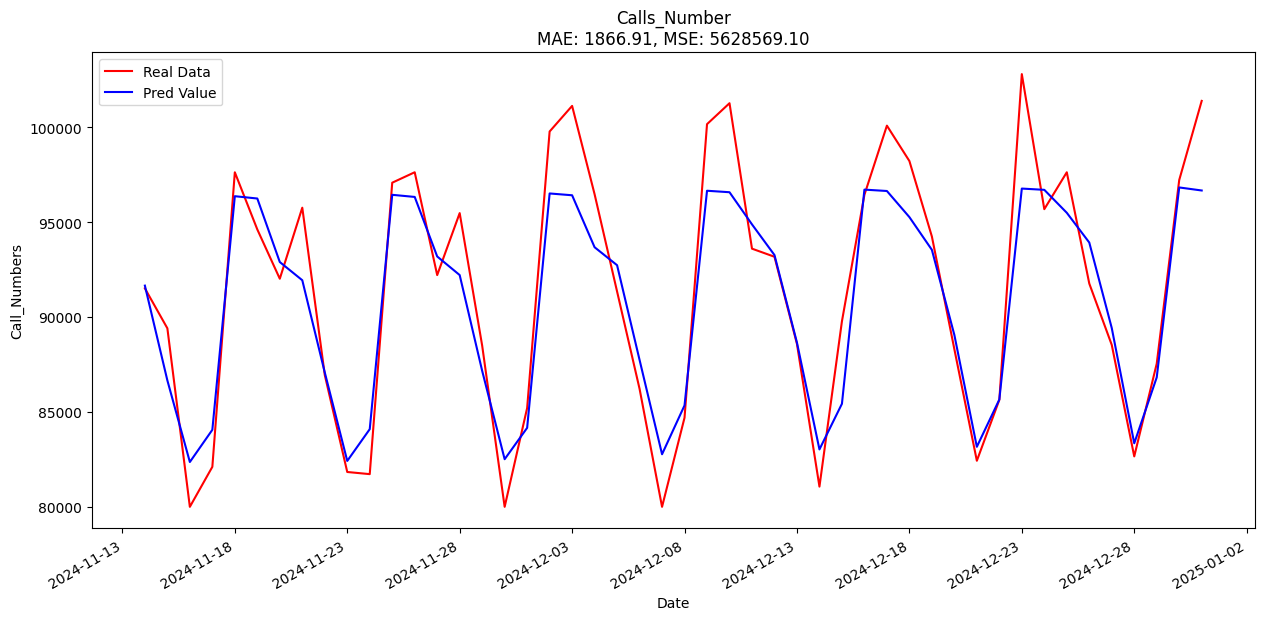

In [38]:

test_dates = df_for_testing.index[-len(testY):]


plt.figure(figsize=(15, 7))  # Set figure size
plt.plot(test_dates, original, color='red', label='Real Data')
plt.plot(test_dates, pred, color='blue', label='Pred Value')

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Adjust interval to your preference
plt.gcf().autofmt_xdate()  # Auto-format x-axis for date

plt.title(f'Calls_Number\nMAE: {mae:.2f}, MSE: {mse:.2f}')
plt.xlabel('Date')
plt.ylabel('Call_Numbers')
plt.legend()
plt.show()

In [39]:
print(pred)


[91656.3281883  86662.11473882 82362.793661   84059.39628154
 96367.21280003 96245.73238635 92898.98621261 91939.75607407
 87083.43806827 82420.05530143 84093.52466297 96440.45128202
 96328.68074369 93192.26184857 92212.01055098 87166.37770939
 82510.39581048 84162.34718812 96511.74208379 96416.50226355
 93678.41567183 92731.43975413 87741.31976116 82771.79343599
 85345.67624176 96654.8292284  96576.81425476 94882.68426895
 93266.36165214 88650.93714345 83026.52433747 85430.96133995
 96714.29290438 96641.46646214 95266.19819641 93542.19057393
 89055.99441111 83164.0972808  85654.86136663 96769.39212847
 96702.77163887 95493.65840507 93925.76313782 89420.38335478
 83349.03498656 86822.21040916 96828.50398588 96668.17931652]


In [40]:
# Scaling the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
merged_df_scaled = merged_df.copy()
merged_df_scaled[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])
merged_df_scaled.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2022-01-01,0.144125,0.000000,0,1,5,52,1,0.961492
2022-01-02,0.095005,0.029932,0,0,6,52,1,0.961492
2022-01-03,0.842561,0.063311,0,0,0,1,1,0.961492
2022-01-04,0.801414,0.097826,0,0,1,1,1,0.961492
2022-01-05,0.641455,0.129414,0,0,2,1,1,0.961492


In [41]:
fullX, fullY = createXY(merged_df_scaled.values, n_past_steps)
fullX = fullX.astype('float32')
fullY = fullY.astype('float32')
print(fullX.shape)
print(fullY.shape)

(1089, 7, 8)
(1089,)


In [42]:
#assgin grid_search best paramas value to best_params_
best_params = grid_search.best_params_
#get paramas from best_params_
optimizer = best_params['optimizer']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
print(f'Optimizer: {optimizer}')
print(f'Batch Size: {batch_size}')
print(f'Epochs: {epochs}')

Optimizer: adam
Batch Size: 32
Epochs: 30


In [43]:
#build final_model
#print(optimizer)
final_model = build_model(optimizer=optimizer)

In [44]:
#final_train
final_model.fit(fullX, fullY, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3902 - mae: 0.3311 - mse: 0.1623
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1855 - mae: 0.2225 - mse: 0.0681
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1221 - mae: 0.2133 - mse: 0.0647
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1014 - mae: 0.2262 - mse: 0.0711
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0821 - mae: 0.2142 - mse: 0.0639
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0802 - mae: 0.2194 - mse: 0.0678
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0660 - mae: 0.2027 - mse: 0.0567
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0569 - mae: 0.1719 - mse: 0.0491
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239 - mae: 0.1028 - mse: 0.0172
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mae: 0.0999 - mse: 0.0162
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239 - m

In [45]:
df_7_days_past=merged_df.iloc[-7:,:]
df_7_days_past.tail()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2024-12-27,88532,727188,0,0,4,52,12,2863065
2024-12-28,82658,726681,0,0,5,52,12,2863065
2024-12-29,87544,729699,0,0,6,52,12,2863065
2024-12-30,97219,734638,0,0,0,1,12,2863065
2024-12-31,101389,738874,0,0,1,1,12,2863065


In [46]:
#test excel reading and original forecast excel file
dfk=pd.read_csv('mock_future_RollCap.csv')

In [47]:
df_endyear_future=pd.read_csv('mock_future_RollCap.csv')
df_endyear_future['date']=pd.to_datetime(df_endyear_future['date'])
df_endyear_future['weekday']=df_endyear_future['date'].dt.dayofweek
merged_df_endyear_future=pd.merge(df_endyear_future,holiday_df,how='left',left_on='date',right_on='date')
merged_df_endyear_future['Holiday_A']=merged_df_endyear_future['holiday'].apply(lambda x: 1 if x in Holiday_A_Names else 0)
merged_df_endyear_future['Holiday_B']=merged_df_endyear_future['holiday'].apply(lambda x: 1 if x not in Holiday_A_Names and x in us_holidays_name else 0)
merged_df_endyear_future.index=pd.to_datetime(merged_df_endyear_future['date'])
merged_df_endyear_future['Total_Presented']=0
merged_df_endyear_future['week_number'] = merged_df_endyear_future['date'].dt.isocalendar().week
merged_df_endyear_future['month'] = merged_df_endyear_future['date'].dt.month #add month column
df_endyear_future=merged_df_endyear_future.loc[:,['Total_Presented','RollCap','Holiday_A','Holiday_B','weekday','week_number','month']]
df_endyear_future

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month
date,,,,,,,
2025-01-01,0,741120,0,1,2,1,1
2025-01-02,0,739430,0,0,3,1,1
2025-01-03,0,739738,0,0,4,1,1
2025-01-04,0,739645,0,0,5,1,1
2025-01-05,0,740563,0,0,6,1,1
...,...,...,...,...,...,...,...
2025-12-27,0,716137,0,0,5,52,12
2025-12-28,0,717011,0,0,6,52,12
2025-12-29,0,722407,0,0,0,1,12


In [48]:
#index date
date_index = df_endyear_future.index
#merge future_monthly_sum
future_monthly_sum_df = pd.read_csv('future_Month_Sum.csv')
#transfer to dailybase
future_monthly_sum_df['date'] = pd.to_datetime(future_monthly_sum_df['date'])
#merging
df_endyear_future['year_month'] = df_endyear_future.index.to_period('M')
future_monthly_sum_df['year_month'] = future_monthly_sum_df['date'].dt.to_period('M')

df_endyear_future = pd.merge(df_endyear_future, future_monthly_sum_df[['year_month', 'monthly_sum']], on='year_month', how='left')
df_endyear_future=df_endyear_future.rename(columns={'monthly_sum':'monthly_sum'})
df_endyear_future.index = date_index
df_endyear_future.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,year_month,monthly_sum
date,,,,,,,,,
2025-01-01,0,741120,0,1,2,1,1,2025-01,2884828
2025-01-02,0,739430,0,0,3,1,1,2025-01,2884828
2025-01-03,0,739738,0,0,4,1,1,2025-01,2884828
2025-01-04,0,739645,0,0,5,1,1,2025-01,2884828
2025-01-05,0,740563,0,0,6,1,1,2025-01,2884828


In [49]:
future_monthly_sum_df.head()

,date,monthly_sum,year_month
0,2025-01-01,2884828,2025-01
1,2025-02-01,2622891,2025-02
2,2025-03-01,2891966,2025-03
3,2025-04-01,2769522,2025-04
4,2025-05-01,2776798,2025-05


In [50]:
df_endyear_future['Total_Presented']=0
df_endyear_future=df_endyear_future[['Total_Presented','RollCap','Holiday_A','Holiday_B','weekday','week_number','month','monthly_sum']]
#check holiday append
df_endyear_future[df_endyear_future['Holiday_A']==1]

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2025-12-25,0,715750,1,0,3,52,12,2865375


In [51]:
# Combine past and future data
combined_data = pd.concat([df_7_days_past, df_endyear_future])
# Separate the columns to be scaled and not to be scaled
data_to_scale = combined_data[['Total_Presented', 'RollCap', 'monthly_sum']]
data_not_to_scale = combined_data.drop(['Total_Presented', 'RollCap', 'monthly_sum'], axis=1)
# Scale the necessary columns with the original scaler
scaled_data = scaler.transform(data_to_scale)
# Reconstruct the dataframe
scaled_df = pd.DataFrame(scaled_data, columns=['Total_Presented', 'RollCap', 'monthly_sum'])
final_scaled_data = pd.concat([scaled_df, data_not_to_scale.reset_index(drop=True)], axis=1)

#index date
final_scaled_data.index = combined_data.index
final_scaled_data=final_scaled_data[['Total_Presented','RollCap','Holiday_A','Holiday_B','weekday','week_number','month','monthly_sum']]
# check final_scaled_data
final_scaled_data.head(10)



,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2024-12-25,0.662968,0.867326,1,0,2,52,12,0.827709
2024-12-26,0.442493,0.866160,0,0,3,52,12,0.827709
2024-12-27,0.320859,0.869522,0,0,4,52,12,0.827709
2024-12-28,0.099932,0.868895,0,0,5,52,12,0.827709
2024-12-29,0.283699,0.872628,0,0,6,52,12,0.827709
2024-12-30,0.647585,0.878736,0,0,0,1,12,0.827709
2024-12-31,0.804423,0.883976,0,0,1,1,12,0.827709
2025-01-01,-3.008914,0.886753,0,1,2,1,1,0.895982
2025-01-02,-3.008914,0.884663,0,0,3,1,1,0.895982


In [52]:
final_scaled_array = final_scaled_data.values
final_scaled_array=final_scaled_array.astype('float32')
print(final_scaled_array.dtype)  # check data type
print(final_scaled_array.shape)  # check data shape

float32
(372, 8)


In [53]:
#check model before prediction
final_model.summary()

Model: "Conv1D_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 7, 64)          │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Conv (Dropout)          │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 7, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 7, 96)          │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 7, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 7, 48)          │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 7, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_3 (LSTM)                   │ (None, 48)             │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Dense (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,205 (1.22 MB)

 Trainable params: 106,401 (415.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 212,804 (831.27 KB)

In [54]:
input_shape = final_model.input_shape
print(input_shape)

(None, 7, 8)


In [55]:
# #compare data_x and final_scaled_array
# all_data = []
# time_step = 7
# for i in range(time_step, len(final_scaled_array)):
#     data_x = []
#     data_x.append(final_scaled_array[i-time_step : i, 0:final_scaled_array.shape[1]])
#     data_x = np.array(data_x)
#     print(data_x.dtype)  # check data type
#     print(data_x.shape)  # check data shape
#     break  # exit the loop

# # check data
# print(data_x.dtype)  # check data type
# print(data_x.shape)  # check data shape

In [56]:
# --- Cell for Pre-Prediction Input Check (Revised to match prediction loop's X creation) ---
# Objective: Verify the shape and dtype of a single input sample (data_x)
#            that will be fed to the model, using the same logic as the prediction loop.
# Assumes:
# - final_scaled_array: NumPy array (shape: total_steps, n_model_features) prepared for prediction.
# - n_past_steps: The look-back window size (e.g., 7).
# - final_model: (Optional for this check, but good for shape comparison) Your trained Keras model.

print("--- Checking a sample input for the prediction model (using prediction loop's X creation logic) ---")



if 'final_scaled_array' in locals() and final_scaled_array is not None and \
   'n_past_steps' in locals() and len(final_scaled_array) >= n_past_steps:

    # 1. Extract the first input window that would be used in the prediction loop
    # This window uses rows 0 to n_past_steps-1 from final_scaled_array
    first_input_window_for_model = final_scaled_array[0:n_past_steps, :]

    # 2. Reshape for Keras model input: shape (1, n_past_steps, n_model_features)
    # THIS IS THE SAME LOGIC AS IN THE PREDICTION LOOP'S CELL
    sample_data_x_for_model = first_input_window_for_model.reshape(1, n_past_steps, final_scaled_array.shape[1])

    print(f"Shape of a single input sample (sample_data_x_for_model): {sample_data_x_for_model.shape}")
    print(f"Data type of a single input sample (sample_data_x_for_model): {sample_data_x_for_model.dtype}")

    # Optional: Compare with model's expected input shape
    if 'final_model' in locals() and hasattr(final_model, 'input_shape'):
        print(f"Model's expected input shape (excluding batch size): {final_model.input_shape[1:]}")
        if final_model.input_shape[1:] == sample_data_x_for_model.shape[1:]:
            print("Sample input shape matches model's expected input shape (excluding batch size). OK.")
        else:
            print("WARNING: Sample input shape DOES NOT match model's expected input shape!")
    else:
        print("Skipping model input shape comparison (final_model not found or has no input_shape attribute).")
else:
    print("Warning: 'final_scaled_array' or 'n_past_steps' is not defined, or 'final_scaled_array' is empty/too short.")
    if 'final_scaled_array' in locals() and 'n_past_steps' in locals() :
         print(f"Length of final_scaled_array: {len(final_scaled_array) if final_scaled_array is not None else 'None'}, n_past_steps: {n_past_steps}")


print("--- End of Pre-Prediction Input Check ---")

--- Checking a sample input for the prediction model (using prediction loop's X creation logic) ---
Shape of a single input sample (sample_data_x_for_model): (1, 7, 8)
Data type of a single input sample (sample_data_x_for_model): float32
Model's expected input shape (excluding batch size): (7, 8)
Sample input shape matches model's expected input shape (excluding batch size). OK.
--- End of Pre-Prediction Input Check ---


In [57]:
# --- Iterative Prediction Loop ---
# Assumes the following are pre-defined and available in the current scope:
# - final_model: Your trained Keras model object.
# - final_scaled_array: NumPy array (shape: total_steps_for_prediction, n_model_features).
#                       This array should start with 'n_past_steps' of actual scaled historical data,
#                       followed by rows for future dates where the target variable (column 0, e.g., 'Total_Presented')
#                       is a placeholder (e.g., scaled zero), and other features are simulated/known future values (scaled).
# - n_past_steps: The look-back window size for your model (integer, e.g., 7).

print("Starting iterative prediction for future steps...")

# List to store the SCALED predictions for each future step
scaled_predictions_future = []

# The loop iterates from the first future time step for which a prediction is needed.
# 'i' is the index in final_scaled_array of the day currently being predicted.
for i in range(n_past_steps, len(final_scaled_array)):
    # 1. Extract the current input window: shape (n_past_steps, n_model_features)
    # This window takes n_past_steps rows, ending just before the current step 'i'.
    current_input_window_scaled = final_scaled_array[i - n_past_steps : i, :]

    # 2. Reshape for Keras model input: shape (1, n_past_steps, n_model_features)
    # (1 sample, n_past_steps time steps, n_model_features features per step)
    model_input_X = current_input_window_scaled.reshape(1, n_past_steps, final_scaled_array.shape[1])

    # 3. Get scaled prediction from the model.
    # predict() returns a 2D array, e.g., [[value]] if output_dim is 1.
    # verbose=0 is used to keep the loop output clean from Keras's own prediction logs.
    predicted_value_array_scaled = final_model.predict(model_input_X, verbose=0)
    
    # 4. Extract the scalar prediction value from the 2D array.
    current_prediction_scalar_scaled = predicted_value_array_scaled[0, 0]
    scaled_predictions_future.append(current_prediction_scalar_scaled)

    # 5. Autoregressive update:
    # Update the target variable (assumed to be column 0, e.g., 'Total_Presented')
    # for the current time step 'i' in final_scaled_array with the SCALAR prediction just made.
    # This updated value will then be part of the input window for the next prediction step.
    final_scaled_array[i, 0] = current_prediction_scalar_scaled

# --- End of Prediction Loop ---

print(f"Iterative prediction complete. Generated {len(scaled_predictions_future)} scaled future predictions.")

# The list 'scaled_predictions_future' now holds the sequence of scaled predictions.
# The array 'final_scaled_array' has also been updated in place with these predictions
# in its target variable column (column 0) for the future steps.

# Next step (typically in a new cell) would be to take 'scaled_predictions_future'
# and inverse_transform it back to the original data scale.
# Example:
# y_pred_future_scaled_np = np.array(scaled_predictions_future).reshape(-1, 1)
# N_FEATURES_SCALER_FIT_ON = 3 # Or your actual number
# temp_for_inverse = np.repeat(y_pred_future_scaled_np, N_FEATURES_SCALER_FIT_ON, axis=1)
# y_pred_future_original_scale = scaler.inverse_transform(temp_for_inverse)[:, 0]
# Then, combine y_pred_future_original_scale with dates for plotting/analysis.

Starting iterative prediction for future steps...
Iterative prediction complete. Generated 365 scaled future predictions.


In [58]:
scaled_predictions_future

[0.6028046,
 0.5310017,
 0.41885322,
 0.22748503,
 0.2905927,
 0.82562995,
 0.76113695,
 0.62957495,
 0.5236809,
 0.38066503,
 0.22570156,
 0.3150649,
 0.83410925,
 0.7896812,
 0.6505504,
 0.53391254,
 0.38884905,
 0.22999206,
 0.32397893,
 0.83719873,
 0.7996019,
 0.66410804,
 0.5458218,
 0.3970491,
 0.23309046,
 0.32950312,
 0.83910465,
 0.8054493,
 0.6730952,
 0.55374587,
 0.40060923,
 0.23421517,
 0.33086526,
 0.8395177,
 0.8065695,
 0.67410356,
 0.55331683,
 0.39421323,
 0.23032364,
 0.3101405,
 0.8332591,
 0.7908032,
 0.65621173,
 0.53918576,
 0.3792047,
 0.22552863,
 0.2975121,
 0.83120954,
 0.78604877,
 0.64820296,
 0.53228426,
 0.3696607,
 0.21779566,
 0.28281707,
 0.82760304,
 0.7789271,
 0.6394537,
 0.5246787,
 0.35928,
 0.2088849,
 0.2683271,
 0.82081616,
 0.7771614,
 0.6462452,
 0.53874743,
 0.37731168,
 0.21052474,
 0.2809933,
 0.830454,
 0.8000365,
 0.6659132,
 0.5506472,
 0.37796798,
 0.20064034,
 0.2666042,
 0.8223656,
 0.7881793,
 0.6534931,
 0.5412011,
 0.36543953,
 

In [59]:
print("\nStarting inverse scaling of future predictions...")
TARGET_COLUMN_NAME = 'Total_Presented' # The name of your target column
# 1. Consolidate scaled_predictions_future into a 2D NumPy array (shape: n_samples, 1)
if scaled_predictions_future and isinstance(scaled_predictions_future[0], np.ndarray):
    # If the elements in the list are already NumPy arrays of shape (1,1) or similar
    scaled_predictions_array = np.vstack(scaled_predictions_future)
else:
    # If the elements in the list are scalars
    scaled_predictions_array = np.array(scaled_predictions_future).reshape(-1, 1)

print(f"Shape of scaled_predictions_array for inverse transform: {scaled_predictions_array.shape}")

# 2. Prepare the array for inverse_transform
#    The scaler expects an input array with the same number of features
#    and in the same order as when it was fit.

# Get the number of features the scaler was fit on
n_scaler_features = scaler.n_features_in_
print(f"Scaler was fit on {n_scaler_features} features.")

# Get the names of the features the scaler was fit on (if available and scaler was fit on a DataFrame)
try:
    scaler_feature_names = scaler.feature_names_in_
    print(f"Scaler was fit on features: {list(scaler_feature_names)}") # Convert to list for cleaner printing
except AttributeError:
    scaler_feature_names = None
    print("Warning: scaler.feature_names_in_ not available. Assuming target was the first scaled feature if no further logic is implemented.")

# Determine the index of the target column in the scaler's training data
# Ensure TARGET_COLUMN_NAME exactly matches the name used when fitting the scaler
target_column_index_in_scaler = 0 # Default assumption: target column is the first feature

if scaler_feature_names is not None:
    try:
        target_column_index_in_scaler = list(scaler_feature_names).index(TARGET_COLUMN_NAME)
        print(f"Target column '{TARGET_COLUMN_NAME}' was at index {target_column_index_in_scaler} during scaling.")
    except ValueError:
        print(f"ERROR: Target column '{TARGET_COLUMN_NAME}' not found in scaler's feature names: {list(scaler_feature_names)}.")
        print(f"Using index 0 as a fallback for target_column_index_in_scaler, but inverse transform might be incorrect for the target.")
        # In a real application, you might want to raise an error or implement stricter error handling
        # if the target column is not found.
        # raise ValueError(f"Target column '{TARGET_COLUMN_NAME}' not found in scaler's feature names: {list(scaler_feature_names)}")
else:
    print(f"Warning: scaler.feature_names_in_ was not available. Assuming target column '{TARGET_COLUMN_NAME}' corresponds to index 0 in the scaled data. This might be incorrect.")


# Create a temporary array with the correct number of columns for inverse_transform.
# Initialize with a neutral scaled value (e.g., 0.5, as MinMaxScaler typically scales to 0-1 range).
# If features are scaled independently (e.g., MinMaxScaler), these values in non-target columns
# do not affect the inverse transformation of the target column.
temp_array_for_inverse = np.full((len(scaled_predictions_array), n_scaler_features), 0.5)

# Place the scaled predictions into the correct column of this temporary array.
temp_array_for_inverse[:, target_column_index_in_scaler] = scaled_predictions_array.flatten()
print(f"Shape of temp_array_for_inverse (after placing predictions): {temp_array_for_inverse.shape}")

# 3. Apply inverse transform.
inversed_predictions_all_features = scaler.inverse_transform(temp_array_for_inverse)
print(f"Shape of inversed_predictions_all_features: {inversed_predictions_all_features.shape}")

# 4. Extract the predictions for the target variable using its known index.
y_pred_future_original_scale = inversed_predictions_all_features[:, target_column_index_in_scaler]
y_pred_future_original_scale_integer = np.round(y_pred_future_original_scale).astype(int)
print(f"\nInverse scaling complete. {len(y_pred_future_original_scale)} predictions in original scale.")
print("\nSample of future predictions in original scale (first 5):")
print(y_pred_future_original_scale_integer[:5])
if len(y_pred_future_original_scale_integer) > 5:
    print("\nSample of future predictions in original scale (last 5):")
    print(y_pred_future_original_scale_integer[-5:])

# Now 'y_pred_future_original_scale' contains your final predictions in the original data scale.
# You can then combine this with your future dates for plotting or further analysis.
# For example:
# if 'future_daily_dates' in locals() and len(future_daily_dates) == len(y_pred_future_original_scale):
#     import pandas as pd
#     df_final_predictions_output = pd.DataFrame({
#         'date': future_daily_dates, # The dates corresponding to the predictions
#         f'Predicted_{TARGET_COLUMN_NAME}': y_pred_future_original_scale
#     })
#     print("\nDataFrame with final predictions (first 5 rows):")
#     print(df_final_predictions_output.head())
# else:
#     print("\nWarning: 'future_daily_dates' not available or length mismatch. Cannot create final prediction DataFrame with dates.")



Starting inverse scaling of future predictions...
Shape of scaled_predictions_array for inverse transform: (365, 1)
Scaler was fit on 3 features.
Scaler was fit on features: ['Total_Presented', 'RollCap', 'monthly_sum']
Target column 'Total_Presented' was at index 0 during scaling.
Shape of temp_array_for_inverse (after placing predictions): (365, 3)
Shape of inversed_predictions_all_features: (365, 3)

Inverse scaling complete. 365 predictions in original scale.

Sample of future predictions in original scale (first 5):
[96028 94119 91137 86049 87727]

Sample of future predictions in original scale (last 5):
[83098 84878 98391 97521 96131]


In [60]:
df_endyear_future.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2025-01-01,0,741120,0,1,2,1,1,2884828
2025-01-02,0,739430,0,0,3,1,1,2884828
2025-01-03,0,739738,0,0,4,1,1,2884828
2025-01-04,0,739645,0,0,5,1,1,2884828
2025-01-05,0,740563,0,0,6,1,1,2884828


In [61]:
forecasted_data=pd.DataFrame(y_pred_future_original_scale_integer,index=dfk['date'],columns=['Total_Presented'])
forecasted_data.index=pd.to_datetime(forecasted_data.index)
merge_forecasted_data_final=pd.merge(forecasted_data,df_endyear_future,how='left',left_index=True,right_index=True)
merge_forecasted_data_final['weekday']=merge_forecasted_data_final.index.dayofweek
merge_forecasted_data_final['week_number'] = merge_forecasted_data_final.index.isocalendar().week
merge_forecasted_data_final['month'] = merge_forecasted_data_final.index.month #add month column
merge_forecasted_data_final['monthly_sum']=merge_forecasted_data_final['monthly_sum'].fillna(0)
merge_forecasted_data_final = merge_forecasted_data_final.rename(columns={'Total_Presented_x': 'Total_Presented'})
merge_forecasted_data_final=merge_forecasted_data_final[['Total_Presented','RollCap','Holiday_A','Holiday_B','weekday','week_number','month','monthly_sum']]
merge_forecasted_data_final.head()



,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2025-01-01,96028,741120,0,1,2,1,1,2884828
2025-01-02,94119,739430,0,0,3,1,1,2884828
2025-01-03,91137,739738,0,0,4,1,1,2884828
2025-01-04,86049,739645,0,0,5,1,1,2884828
2025-01-05,87727,740563,0,0,6,1,1,2884828


In [62]:
merge_forecasted_data_final.tail()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum
date,,,,,,,,
2025-12-27,83098,716137,0,0,5,52,12,2865375
2025-12-28,84878,717011,0,0,6,52,12,2865375
2025-12-29,98391,722407,0,0,0,1,12,2865375
2025-12-30,97521,726243,0,0,1,1,12,2865375
2025-12-31,96131,726698,0,0,2,1,12,2865375


In [63]:
# add year_month column
merge_forecasted_data_final['year_month'] = merge_forecasted_data_final.index.strftime('%Y-%m')

# cal monthly_sum for total_presented
monthly_presented_sum = merge_forecasted_data_final.groupby('year_month')['Total_Presented'].sum()

# cal scaling factor
scaling_factor = merge_forecasted_data_final['monthly_sum'] / monthly_presented_sum[merge_forecasted_data_final['year_month']].values

# adjusted Total_Presented
merge_forecasted_data_final['Total_Presented_adj'] = merge_forecasted_data_final['Total_Presented'] * scaling_factor
merge_forecasted_data_final['Total_Presented_adj'] = np.round(merge_forecasted_data_final['Total_Presented_adj']).astype(int)
# Check data
merge_forecasted_data_final.head()

,Total_Presented,RollCap,Holiday_A,Holiday_B,weekday,week_number,month,monthly_sum,year_month,Total_Presented_adj
date,,,,,,,,,,
2025-01-01,96028,741120,0,1,2,1,1,2884828,2025-01,94859
2025-01-02,94119,739430,0,0,3,1,1,2884828,2025-01,92974
2025-01-03,91137,739738,0,0,4,1,1,2884828,2025-01,90028
2025-01-04,86049,739645,0,0,5,1,1,2884828,2025-01,85002
2025-01-05,87727,740563,0,0,6,1,1,2884828,2025-01,86659


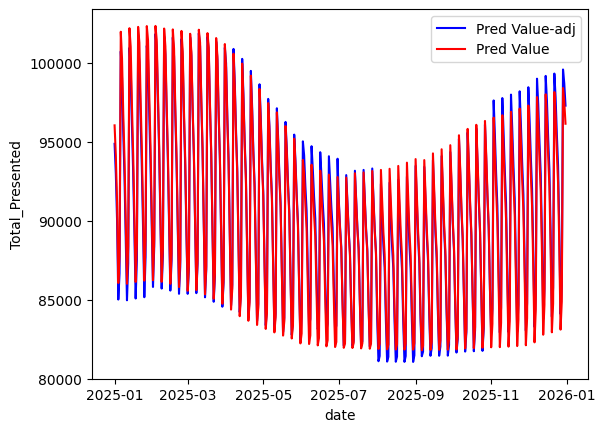

In [64]:
plt.plot(merge_forecasted_data_final.Total_Presented_adj, color='blue', label='Pred Value-adj')
plt.plot(merge_forecasted_data_final.Total_Presented, color='red', label='Pred Value')

plt.xlabel('date')
plt.ylabel('Total_Presented')
plt.legend()
plt.show()

In [65]:
merge_forecasted_data_final.to_excel("Forecasted_Call.xlsx",header=True)

In [66]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model

In [67]:
my_model.save('Model_future_value.h5')
print('Model Saved')

Model Saved


In [68]:
scaler

MinMaxScaler()

In [69]:
import pickle
scalerfile='scaler_model_future_value.pkl'
pickle.dump(scaler,open(scalerfile,'wb'))